# Gibson Lanni Model with background.

In [1]:
import os
import sys
import numpy as np
from numpy.random import randint, choice, randn
import torch
import skimage.morphology
from skimage.morphology import ball, octahedron, cube

import scipy.special

from matplotlib import cm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.distributions as dist
import torch.nn.functional as F
from   scipy.stats import lognorm
import torch.special as S
from fft_conv_pytorch import fft_conv

In [2]:
def make_ball(r = 20, datasize = [128, 128, 128]):
    data     = np.zeros(datasize)
    datasize = np.array(datasize)
    s        = 'ball' # 'octahedron', 'cube'
    form     = getattr(skimage.morphology, s)(r).astype(np.float32)
    z, x, y  = datasize // 2 - r
    z_max    = min(z + form.shape[0], datasize[0])
    x_max    = min(x + form.shape[1], datasize[1])
    y_max    = min(y + form.shape[2], datasize[2])
    data[z : z + form.shape[0],
         x : x + form.shape[1],
         y : y + form.shape[2],]\
    += \
    form[0 : z_max - z        ,
         0 : x_max - x        ,
         0 : y_max - y        ,]
    data = data > 0
    data = torch.from_numpy(data).to(torch.float32)
    data = data.unsqueeze(0)
    return data

In [3]:
data = make_ball(r=20, datasize=[240, 128, 128])
nd_data = data.detach().numpy().copy()

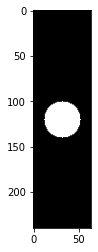

In [4]:
plt.imshow(data[0, :, 64, 32:96], cmap='gray', vmax=1, vmin=0)

In [5]:
dirpath = "_beads_roi_extracted_stackreg"
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))][:-1]
print(beadslist)
label = torch.load(beadslist[0], map_location="cuda").to(torch.float32)

['_beads_roi_extracted_stackreg/beads_001_roi000.pt', '_beads_roi_extracted_stackreg/beads_001_roi001.pt', '_beads_roi_extracted_stackreg/beads_001_roi002.pt', '_beads_roi_extracted_stackreg/beads_001_roi003.pt', '_beads_roi_extracted_stackreg/beads_001_roi004.pt', '_beads_roi_extracted_stackreg/beads_002_roi000.pt', '_beads_roi_extracted_stackreg/beads_002_roi001.pt', '_beads_roi_extracted_stackreg/beads_002_roi002.pt']


In [6]:
loss_fn = nn.MSELoss()

def normalize(array):
    return array / torch.sum(array)

def train_loop(obj, model, label, optimizer, epoch):
    for _ in range(epoch):
        if obj.dim() == 4:
            obj = obj.unsqueeze(0)
        x = model(obj)
        if x.dim() == 5:
            x = x.squeeze(0)
        loss = loss_fn(x, label)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        if _ % 100 == 0:
            print(f'epoch {_}, loss {loss:.8f}')
    return loss.item()

In [7]:
class Emission(nn.Module):
    def __init__(self, params, log_ez0):
        super().__init__()
        self.log_ez0  = log_ez0

    def forward(self, x):
        x = x * torch.exp(self.log_ez0)
        return x
    
    def sample(self, x, params):
        b = x.shape[0]
        pz0  = dist.LogNormal(loc   = torch.tensor(float(params["mu_z"])).view( b,1,1,1,1).expand(*x.shape),
                              scale = torch.tensor(float(params["sig_z"])).view(b,1,1,1,1).expand(*x.shape),)
        x    = x * pz0.sample().to(x.device)
        x    = torch.clip(x, min=0., max=1.)
        return x

class Blur(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.device      = params["device"]
        self.use_fftconv = params["use_fftconv"]
        if params["blur_mode"] == "gaussian":
            psf_model     = GaussianModel(params)
        elif params["blur_mode"] == "gibsonlanni":
            psf_model     = GibsonLanniModel(params)
        else:
            raise(NotImplementedError(f'blur_mode {params["blur_mode"]} is not implemented. Try "gaussian" or "gibsonlanni".'))
        self.init_psf_rz = torch.tensor(psf_model.PSF_rz, requires_grad=True).float().to(self.device)
        self.psf_rz      = nn.Parameter(self.init_psf_rz.detach().clone())
        self.psf_rz_s0   = self.psf_rz.shape[0]
        xy               = torch.meshgrid(torch.arange(params["size_y"]),
                                          torch.arange(params["size_x"]),
                                          indexing='ij')
        r = torch.tensor(psf_model.r)
        x0 = (params["size_x"] - 1) / 2
        y0 = (params["size_y"] - 1) / 2
        r_pixel = torch.sqrt((xy[1] - x0) ** 2 + (xy[0] - y0) ** 2) * params["res_lateral"]
        rs0, = r.shape
        self.rps0, self.rps1 = r_pixel.shape
        r_e = r[:, None, None].expand(rs0, self.rps0, self.rps1)
        r_pixel_e = r_pixel[None].expand(rs0, self.rps0, self.rps1)
        r_index = torch.argmin(torch.abs(r_e- r_pixel_e), dim=0)
        r_index_fe = r_index.flatten().expand(self.psf_rz_s0, -1)
        self.r_index_fe = r_index_fe.to(self.device)
        self.z_pad   = int((params["size_z"] - params["res_axial"] // params["res_lateral"] + 1) // 2)
        self.x_pad   = (params["size_x"]) // 2
        self.y_pad   = (params["size_y"]) // 2
        self.stride  = (params["scale"], 1, 1)
        
    def forward(self, x):
        psf = torch.gather(self.psf_rz, 1, self.r_index_fe)
        psf = psf / torch.sum(psf)
        psf = psf.reshape(self.psf_rz_s0, self.rps0, self.rps1)
        if self.use_fftconv:
            _x   = fft_conv(signal  = x                                    ,
                            kernel  = psf                                  ,
                            stride  = self.stride                          ,
                            padding = (self.z_pad, self.x_pad, self.y_pad,),
                            )
        else:
            _x   = F.conv3d(input   = x                                    ,
                            weight  = psf                                  ,
                            stride  = self.stride                          ,
                            padding = (self.z_pad, self.x_pad, self.y_pad,),
                            )
        return _x

    def show_psf_3d(self):
        psf = torch.gather(self.psf_rz, 1, self.r_index_fe)
        psf = psf / torch.sum(psf)
        psf = psf.reshape(self.psf_rz_s0, self.rps0, self.rps1)
        return psf
    
    def l2_psf_rz(self):
        return torch.mean((self.psf_rz - self.init_psf_rz) ** 2)


class GaussianModel():
    def __init__(self, params):
        oversampling = 1    # Defines the upsampling ratio on the image space grid for computations
        size_x = params["size_x"]
        size_y = params["size_y"]
        size_z = params["size_z"]
        bet_xy = params["bet_xy"]
        bet_z = params["bet_z" ]
        x0 = (size_x - 1) / 2
        y0 = (size_y - 1) / 2
        z0 = (size_z - 1) / 2
        res_lateral = params["res_lateral"]#0.05  # microns # # # # param # # # #
        max_radius = round(np.sqrt((size_x - x0) * (size_x - x0) + (size_y - y0) * (size_y - y0)))
        self.r = res_lateral * np.arange(0, oversampling * max_radius) / oversampling
        xy = np.meshgrid(np.arange(params["size_z"]), np.arange(max_radius), indexing="ij")
        distance = np.sqrt((xy[1] / bet_xy) ** 2 + ((xy[0] - z0) / bet_z) ** 2)
        self.PSF_rz = np.exp(- distance ** 2)

    def __call__(self):
        return self.PSF_rz


class GibsonLanniModel():
    def __init__(self, params):
        size_x = params["size_x"]#256 # # # # param # # # #
        size_y = params["size_y"]#256 # # # # param # # # #
        size_z = params["size_z"]#128 # # # # param # # # #

        # Precision control
        num_basis    = 100  # Number of rescaled Bessels that approximate the phase function
        num_samples  = 1000 # Number of pupil samples along radial direction
        oversampling = 1    # Defines the upsampling ratio on the image space grid for computations

        # Microscope parameters
        NA          = params["NA"]        #1.1   # # # # param # # # #
        wavelength  = params["wavelength"]#0.910 # microns # # # # param # # # #
        M           = params["M"]         #25    # magnification # # # # param # # # #
        ns          = params["ns"] #1.33  # specimen refractive index (RI)
        ng0         = params["ng0"]#1.5   # coverslip RI design value
        ng          = params["ng"] #1.5   # coverslip RI experimental value
        ni0         = params["ni0"]#1.5   # immersion medium RI design value
        ni          = params["ni"] #1.5   # immersion medium RI experimental value
        ti0         = params["ti0"]#150   # microns, working distance (immersion medium thickness) design value
        tg0         = params["tg0"]#170   # microns, coverslip thickness design value
        tg          = params["tg"] #170   # microns, coverslip thickness experimental value
        res_lateral = params["res_lateral"]#0.05  # microns # # # # param # # # #
        res_axial   = params["res_axial"]#0.5   # microns # # # # param # # # #
        pZ          = params["pZ"]       # 2 microns, particle distance from coverslip

        # Scaling factors for the Fourier-Bessel series expansion
        min_wavelength = 0.436 # microns
        scaling_factor = NA * (3 * np.arange(1, num_basis + 1) - 2) * min_wavelength / wavelength
        x0 = (size_x - 1) / 2
        y0 = (size_y - 1) / 2
        max_radius = round(np.sqrt((size_x - x0) * (size_x - x0) + (size_y - y0) * (size_y - y0)))
        r = res_lateral * np.arange(0, oversampling * max_radius) / oversampling
        self.r = r
        a = min([NA, ns, ni, ni0, ng, ng0]) / NA
        rho = np.linspace(0, a, num_samples)

        z = res_axial * np.arange(-size_z / 2, size_z /2) + res_axial / 2

        OPDs = pZ * np.sqrt(ns * ns - NA * NA * rho * rho) # OPD in the sample
        OPDi = (z.reshape(-1,1) + ti0) * np.sqrt(ni * ni - NA * NA * rho * rho) - ti0 * np.sqrt(ni0 * ni0 - NA * NA * rho * rho) # OPD in the immersion medium
        OPDg = tg * np.sqrt(ng * ng - NA * NA * rho * rho) - tg0 * np.sqrt(ng0 * ng0 - NA * NA * rho * rho) # OPD in the coverslip
        W    = 2 * np.pi / wavelength * (OPDs + OPDi + OPDg)
        phase = np.cos(W) + 1j * np.sin(W)
        J = scipy.special.jv(0, scaling_factor.reshape(-1, 1) * rho)
        C, residuals, _, _ = np.linalg.lstsq(J.T, phase.T)
        b = 2 * np.pi * r.reshape(-1, 1) * NA / wavelength
        J0 = lambda x: scipy.special.j0(x)
        J1 = lambda x: scipy.special.j1(x)
        denom = scaling_factor * scaling_factor - b * b
        R = scaling_factor * J1(scaling_factor * a) * J0(b * a) * a - b * J0(scaling_factor * a) * J1(b * a) * a
        R /= denom
        PSF_rz = (np.abs(R.dot(C))**2).T
        self.PSF_rz = PSF_rz / np.max(PSF_rz)

    def __call__(self):
        return self.PSF_rz


class Noise(nn.Module):
    def __init__(self, sig_eps):
        super().__init__()
        self.sig_eps = sig_eps

    def forward(self, x):
        x = x + torch.randn_like(x) * self.sig_eps
        return x


class PreProcess(nn.Module):
    def __init__(self, min, max, params):
        super().__init__()
        self.min = min
        self.max = max
        self.background = nn.Parameter(
            torch.log(torch.tensor(params["background"])))
        self.gamma = dist.Gamma(torch.tensor([1.0]),
                                torch.tensor(params["background"]))
    def forward(self, x):
        x = x + torch.exp(self.background)
        x = torch.clip(x, min=self.min, max=self.max)
        #x = (x - self.min) / (self.max - self.min)
        return x
    def sample(self, x):
        x = x + self.gamma.sample().item()
        x = torch.clip(x, min=self.min, max=self.max)
        #x = (x - self.min) / (self.max - self.min)
        return x
    


class ImagingProcess(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.device     = params["device"]
        self.mu_z       = params["mu_z"]
        self.sig_z      = params["sig_z"]
        self.log_ez0    = nn.Parameter(
            (torch.tensor(params["mu_z"] + 0.5 \
                        * params["sig_z"] ** 2)).to(self.device),
            requires_grad=True)
        self.emission   = Emission(params, log_ez0 = self.log_ez0,)
        self.blur       = Blur(params = params)
        self.noise      = Noise(torch.tensor(params["sig_eps"]))
        self.preprocess = PreProcess(min=0., max=1., params=params)

    def forward(self, x):
        x = self.emission(x)
        x = self.blur(x)
        x = self.preprocess(x)
        return x

/tmp/ipykernel_966114/1547333292.py:147: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residuals, _, _ = np.linalg.lstsq(J.T, phase.T)


stackreg/beads_002_roi000
epoch 0, loss 0.00581170
epoch 100, loss 0.00043411
epoch 200, loss 0.00035822
epoch 300, loss 0.00033326
epoch 400, loss 0.00028941
epoch 500, loss 0.00026772
epoch 600, loss 0.00021795
epoch 700, loss 0.00019338
epoch 800, loss 0.00015350
epoch 900, loss 0.00014369
stackreg/beads_002_roi001
epoch 0, loss 0.00445739
epoch 100, loss 0.00040063
epoch 200, loss 0.00034861
epoch 300, loss 0.00026650
epoch 400, loss 0.00024856
epoch 500, loss 0.00021824
epoch 600, loss 0.00019229
epoch 700, loss 0.00015271
epoch 800, loss 0.00007438
epoch 900, loss 0.00006963


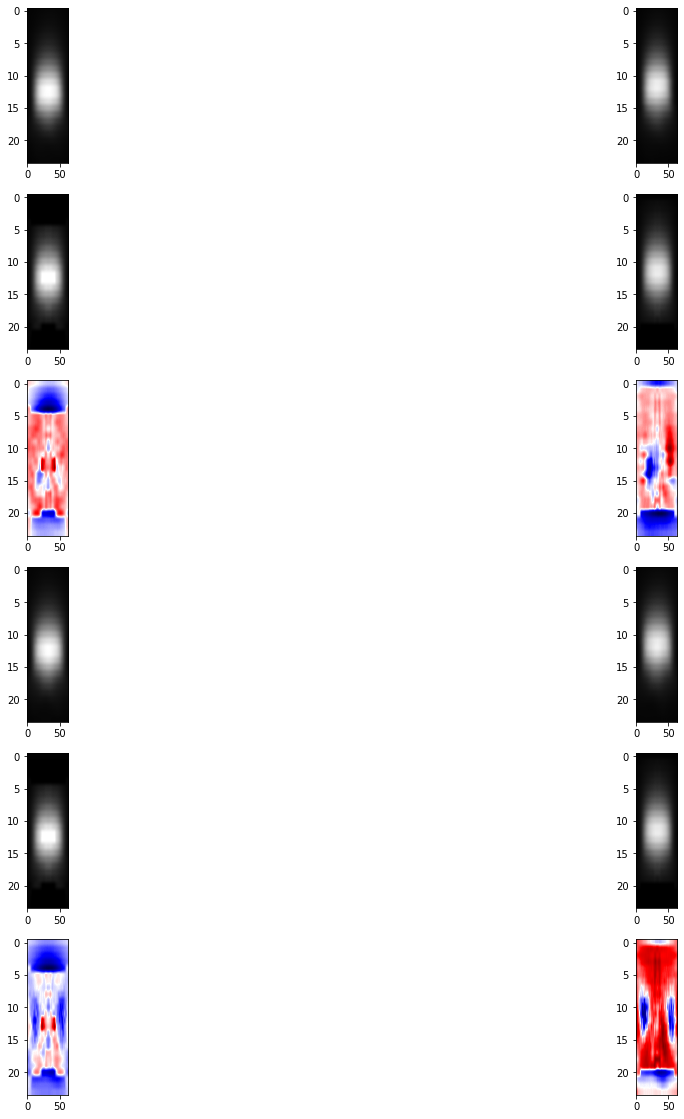

[0.000127551713376306, 6.731374014634639e-05]
stackreg/beads_002_roi000
epoch 0, loss 0.00686583
epoch 100, loss 0.00037548
epoch 200, loss 0.00029262
epoch 300, loss 0.00025831
epoch 400, loss 0.00024611
epoch 500, loss 0.00023683
epoch 600, loss 0.00022720
epoch 700, loss 0.00021545
epoch 800, loss 0.00019872
epoch 900, loss 0.00017246
stackreg/beads_002_roi001
epoch 0, loss 0.00540119
epoch 100, loss 0.00030926
epoch 200, loss 0.00024320
epoch 300, loss 0.00018816
epoch 400, loss 0.00016383
epoch 500, loss 0.00014073
epoch 600, loss 0.00012573
epoch 700, loss 0.00010693
epoch 800, loss 0.00010457
epoch 900, loss 0.00008611


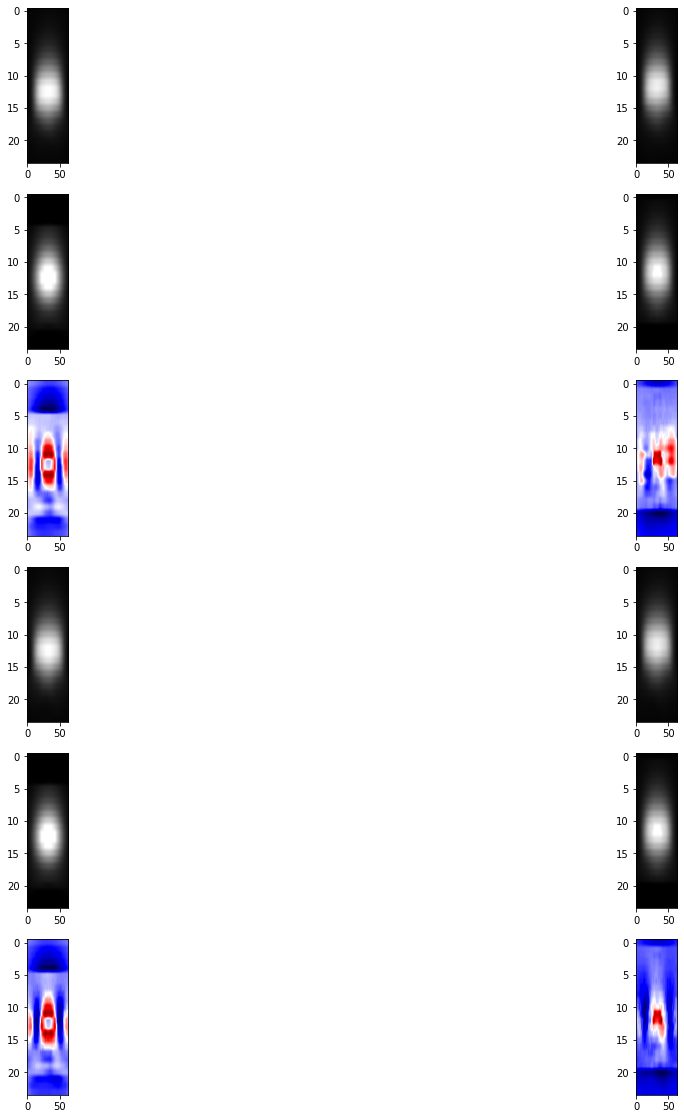

[0.00019582078675739467, 8.065286965575069e-05]


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
kernels = [31, 51]
lossnames = ["gker31", "gker51"]
dc = {}
z = 201
for ker, lossname in zip(kernels, lossnames):
    x = ker
    y = ker
    params = {"use_fftconv":True,
            "mu_z"                  : 0.1                                      ,
            "sig_z"                 : 0.1                                      ,
            "blur_mode"             : "gibsonlanni"                            , "$blur_mode"    : "`gaussian` or `gibsonlanni`"                                     ,
            "size_x"                : x                                       ,
            "size_y"                : y                                       ,
            "size_z"                : 201                                      ,
            "NA"                    : 0.70                                     ,
            "wavelength"            : 0.910                                    , "$wavelength"   : "microns"                                                             ,
            "M"                     : 25                                       , "$M"            : "magnification"                                                       ,
            "ns"                    : 1.4                                      , "$ns"           : "specimen refractive index (RI)"                                      ,
            "ng0"                   : 1.5                                      , "$ng0"          : "coverslip RI design value"                                           ,
            "ng"                    : 1.5                                      , "$ng"           : "coverslip RI experimental value"                                     ,
            "ni0"                   : 1.5                                      , "$ni0"          : "immersion medium RI design value"                                    ,
            "ni"                    : 1.5                                      , "$ni"           : "immersion medium RI experimental value"                              ,
            "ti0"                   : 150                                      , "$ti0"          : "microns, working distance (immersion medium thickness) design value" ,
            "tg0"                   : 170                                      , "$tg0"          : "microns, coverslip thickness design value"                           ,
            "tg"                    : 170                                      , "$tg"           : "microns, coverslip thickness experimental value"                     ,
            "res_lateral"           : 0.05                                     , "$res_lateral"  : "microns"                                                             ,
            "res_axial"             : 0.05                                     , "$res_axial"    : "microns"                                                             ,
            "pZ"                    : 0                                        , "$pZ"           : "microns, particle distance from coverslip"                           ,
            "bet_z"                 : 30.0                                     ,
            "bet_xy"                : 3.0                                      ,
            "sig_eps"               : 0.00                                     ,
            "background"            : 0.01                                     ,
            "scale"                 : 10                                       ,
            "device"                : "cuda"
        }         
    beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
    beadslist.pop(-1)
    beadslist = beadslist[-3:]
    #torch.autograd.set_detect_anomaly(True)
    losses = []
    fig, ax = plt.subplots(nrows = 6, ncols=len(beadslist), figsize=(20, 20))
    for i, bead in enumerate(beadslist):
        dirpath = "_beads_roi_extracted_stackreg"
        label = torch.load(bead, map_location="cuda").to(torch.float32)
        blur = ImagingProcess(params)
        optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
        print(bead[21:-3])
        loss = train_loop(obj, blur, label, optimizer, 1000)
        torch.save(blur.state_dict(), )
        label = label.detach().to("cpu")
        x_label = label[0, :, 64, 32:96]
        y_label = label[0, :, 32:96, 64]
        t = data.to(device).unsqueeze(0)
        t = blur(t).squeeze(0)
        t = t.detach().to('cpu')
        x_img = t[0, :, 64, 32:96]
        y_img = t[0, :, 32:96, 64]
        ax[0, i].imshow(x_label, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[1, i].imshow(x_img, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[2, i].imshow((x_img - x_label + 1) / 2, aspect=10, cmap='seismic')
        ax[3, i].imshow(y_label, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[4, i].imshow(y_img, aspect=10, vmin=0, vmax=1,cmap='gray')
        ax[5, i].imshow((y_img - y_label + 1) / 2, aspect=10, cmap='seismic')
        losses.append(loss)
    plt.show()
    print(losses)
    dc[f"{lossname}"] = losses

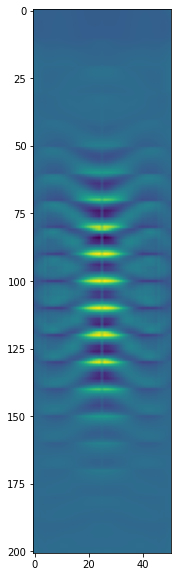

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(blur.blur.show_psf_3d()[:, :, 25].detach().cpu().numpy())
plt.show()

In [ ]:
dc

{'gker3': [0.0013259801780804992,
  0.007455809041857719,
  0.0010801182361319661,
  0.005732984747737646,
  0.0012999705504626036,
  0.0014994635712355375,
  0.0011228949297219515,
  0.0013516899198293686],
 'gker9': [0.0006152081768959761,
  0.006900714244693518,
  0.0004112772876396775,
  0.004901156760752201,
  0.0004609903262462467,
  0.0005237554432824254,
  0.0004031222779303789,
  0.0004934801254421473],
 'gker31': [0.00036255584564059973,
  0.006704788655042648,
  0.00020026040147058666,
  0.004667195957154036,
  0.00021829262550454587,
  0.0002319695195183158,
  0.00021894699602853507,
  0.00023506212164647877],
 'gker61': [0.00023766522645018995,
  0.006557906977832317,
  0.00012321857502683997,
  0.004532914608716965,
  0.00013339181896299124,
  0.000125264807138592,
  0.00011949051986448467,
  0.00014163805462885648]}

In [ ]:
fit12_6 = {'ker3': [0.0016062450595200062,
  0.0076214224100112915,
  0.0012962775072082877,
  0.0059004477225244045,
  0.0016468893736600876,
  0.0019721209537237883,
  0.0012480757432058454,
  0.0015201501082628965],
 'ker9': [0.001343564479611814,
  0.007392687723040581,
  0.00104308663867414,
  0.005579154938459396,
  0.0013445464428514242,
  0.001620264258235693,
  0.0009684868855401874,
  0.0012002362636849284],
 'ker31': [0.0006834962405264378,
  0.006881402805447578,
  0.00047583499690517783,
  0.004972068592905998,
  0.0007150477031245828,
  0.0008839474758133292,
  0.0004427439416758716,
  0.0004963860264979303],
 'ker61': [0.0006305397255346179,
  0.006845209281891584,
  0.00043824277236126363,
  0.0049494849517941475,
  0.0006850848440080881,
  0.0008546472527086735,
  0.00041969932499341667,
  0.00046377157559618354]}

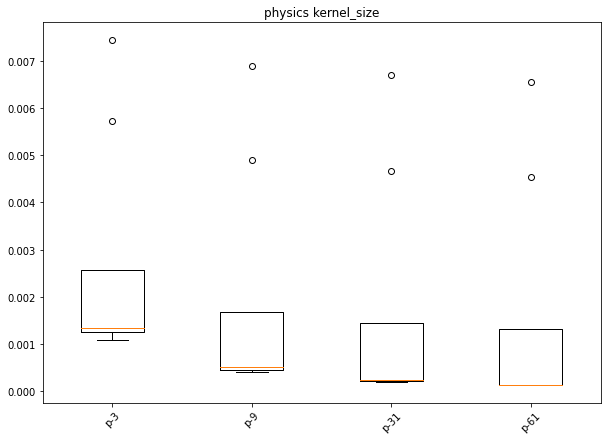

In [ ]:
physics = [dc[i] for i in dc]
labels = ["p-3", "p-9", "p-31", "p-61"]
fig, ax = plt.subplots(figsize=(10, 7))
plt.title("physics kernel_size")
plt.xticks(rotation=45)
vp = ax.boxplot(physics, labels=labels, showfliers=True)
plt.show()

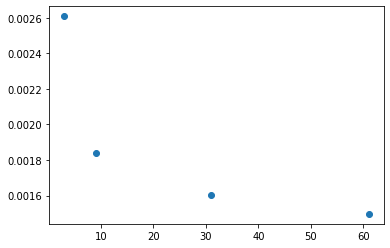

In [ ]:
x = [3, 9, 31, 61]
y = [sum(m)/len(m) for m in physics]
plt.scatter(x, y)
plt.show()

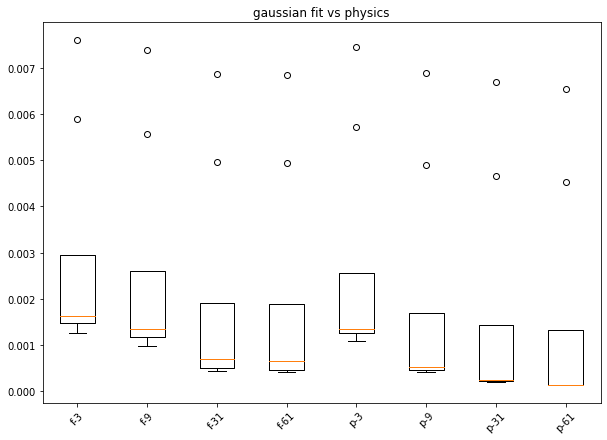

In [ ]:
fitting = [fit12_6[i] for i in fit12_6]
physics = [dc[i] for i in dc]
fitandphy = [*fitting, *physics]
labels = ["f-3", "f-9", "f-31", "f-61", "p-3", "p-9", "p-31", "p-61"]
fig, ax = plt.subplots(figsize=(10, 7))
plt.title("gaussian fit vs physics")
plt.xticks(rotation=45)
vp = ax.boxplot(fitandphy, labels=labels, showfliers=True)
plt.show()

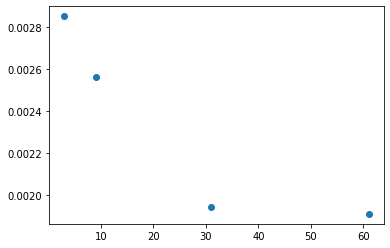

In [ ]:
x = [3, 9, 31, 61]
y = [sum(m)/len(m) for m in fitting]
plt.scatter(x, y)
plt.show()

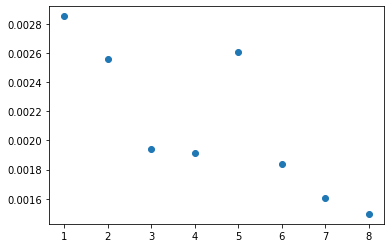

In [ ]:
x = [i for i in range(1, 9)]
y = [sum(m)/len(m) for m in fitandphy]
plt.scatter(x, y)
plt.show()